In [1]:
# General
import numpy as np
import pandas as pd
import re
import pickle

# NLP & Text Processing
import gensim
from gensim.models import Word2Vec
import spacy
import emoji
import contractions
from transformers import pipeline

# Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, f1_score

# Deep Learning
import tensorflow as tf
# from tensorflow.optimizers import AdamW
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler


/Users/Buas/.pyenv/versions/3.11.3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load & Prepare Data

In [2]:
# data

# Load the dataset correctly
df1 = pd.read_csv('/content/test.txt', header=None, sep=';')
df2 = pd.read_csv('/content/train.txt', header=None, sep=';')
df3 = pd.read_csv('/content/val.txt', header=None, sep=';')
df4 = pd.read_excel('/content/FINAL_DATASET.xlsx')

# Rename columns properly
df1.columns = ['text', 'main_category']
df2.columns = ['text', 'main_category']
df3.columns = ['text', 'main_category']
df4 = df4[['Translation', 'Corrected_Emotion']]
df4.rename(columns={'Translation': 'text', 'Corrected_Emotion': 'main_category'}, inplace=True)

# join
df = pd.concat([df1, df2, df3,df4], ignore_index=True)
df.head(3)

FileNotFoundError: [Errno 2] No such file or directory: '/content/test.txt'

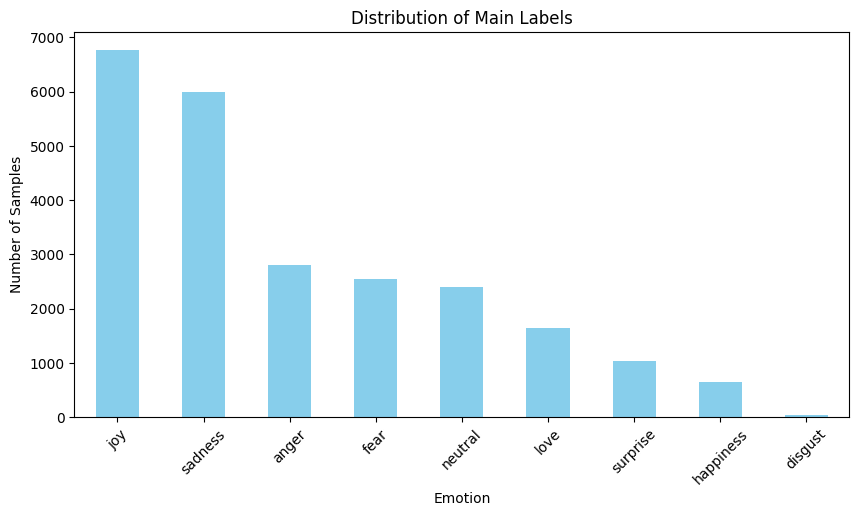

In [ ]:
import matplotlib.pyplot as plt


label_counts = df['main_category'].value_counts()

# Plot distribution
plt.figure(figsize=(10, 5))
label_counts.plot(kind='bar', color='skyblue')
plt.title("Distribution of Main Labels")
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# join joy, love and happiness
df['main_category'] = df['main_category'].replace({'joy': 'happiness', 'love': 'happiness'})

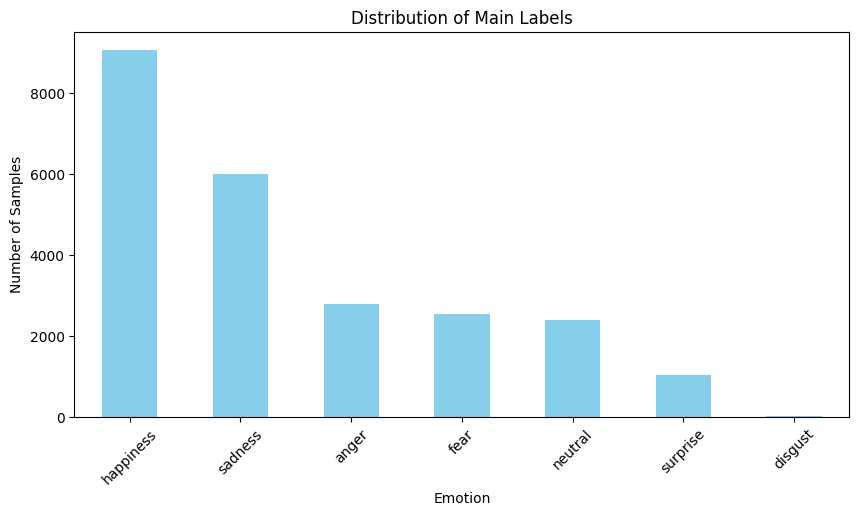

In [ ]:
label_counts = df['main_category'].value_counts()

# Plot distribution
plt.figure(figsize=(10, 5))
label_counts.plot(kind='bar', color='skyblue')
plt.title("Distribution of Main Labels")
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# shape
df.shape

(23855, 2)

In [ ]:
# drop duplicates
df.drop_duplicates(subset=['text'], inplace=True)

print("Shape after removing duplicates:", df.shape)

Shape after removing duplicates: (23180, 2)


In [ ]:
# drop nans
df.dropna(inplace=True)

print("Shape after removing nans:", df.shape)

# Reset index
df.reset_index(drop=True, inplace=True)

Shape after removing nans: (23179, 2)


In [ ]:
# Check unique values in main_category
print("Unique categories:", df['main_category'].unique())

Unique categories: ['sadness' 'happiness' 'fear' 'anger' 'surprise' 'neutral' 'disgust']


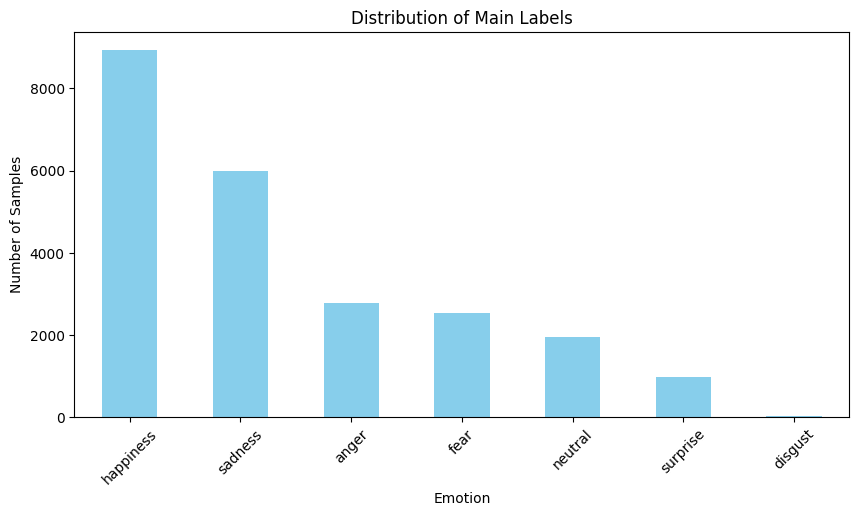

In [ ]:
label_counts = df['main_category'].value_counts()

# Plot distribution
plt.figure(figsize=(10, 5))
label_counts.plot(kind='bar', color='skyblue')
plt.title("Distribution of Main Labels")
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

In [ ]:
import re
import emoji
import contractions

def replace_emojis(text):
    """Convert emojis to their textual descriptions (without colons)."""
    demojized = emoji.demojize(text, delimiters=(" ", " "))  # Convert emojis
    demojized = demojized.replace(":", "").replace("_", " ")  # Format
    return demojized

def clean_text(text):
    text = replace_emojis(text)  # Emojis to text
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove links
    text = re.sub(r"@\w+|#\w+", "", text)  # Remove @mentions and hashtags
    text = re.sub(r"[^a-zA-Z0-9'\[\].,!?]", " ", text)  # Keep only text/punctuation
    text = ''.join([i for i in text if not i.isdigit()])  # Remove numbers
    text = re.sub(r'\[[^\]]*\]', '', text)  # Remove brackets
    text = re.sub(r'(?<=\S)[.,](?=\S)', '', text)  # Fix punctuation
    text = " ".join(text.split())  # Remove extra spaces
    text = re.sub(r'([.!?])\1+', r'\1', text)  # Reduce repeated punctuation
    text = contractions.fix(text)  # Expand contractions
    return text

# Apply cleaning
df['text'] = df['text'].astype(str).apply(clean_text)

# Remove empty texts
df = df[df['text'].str.strip() != '']
print("Dataset shape after cleaning:", df.shape)

# Remove short texts (less than 3 words)
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
df = df[df['text_length'] >= 3]
df.drop(columns=['text_length'], inplace=True)

print("Shape after removing short texts:", df.shape)

Dataset shape after cleaning: (23179, 2)
Shape after removing short texts: (20127, 2)


In [ ]:
import nltk

# Download the correct POS tagger
nltk.download('averaged_perceptron_tagger')

# Download 'averaged_perceptron_tagger_eng' specifically
nltk.download('averaged_perceptron_tagger_eng')  # This line is added

# Manually set the path for NLTK data
import os
nltk_data_path = os.path.join(os.path.expanduser("~"), "nltk_data")
if nltk_data_path not in nltk.data.path:
    nltk.data.path.append(nltk_data_path)

# Re-attempt augmentation
import nlpaug.augmenter.word as naw

syn_aug = naw.SynonymAug(aug_src='wordnet', aug_min=2, aug_max=5, aug_p=0.5)


# Define the augmenter using WordNet
syn_aug = naw.SynonymAug(aug_src='wordnet', aug_min=2, aug_max=5, aug_p=0.5)

# Function to balance dataset with augmentation
def balance_dataset(df, text_col="text", label_col="main_category", augmenter=None):
    class_counts = df[label_col].value_counts()
    max_count = class_counts.max()

    def augment_text(text):
        return augmenter.augment(text) if augmenter else text  # Apply augmentation if augmenter exists

    # Augment underrepresented categories
    augmented_data = pd.concat([
        df[df[label_col] == lbl].sample(n=max_count, replace=True, random_state=42)
        .assign(**{text_col: lambda x: x[text_col].apply(augment_text)})
        for lbl in class_counts.index
    ])

    return augmented_data.reset_index(drop=True)""

# Apply augmentation
balanced_df = balance_dataset(df, "text", "main_category", augmenter=syn_aug)

# Verify the new class distribution
print("Original Class Distribution:\n", df["main_category"].value_counts())
print("Balanced Class Distribution:\n", balanced_df["main_category"].value_counts())

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Original Class Distribution:
 main_category
happiness    8091
sadness      5328
anger        2516
fear         2289
neutral      1077
surprise      807
disgust        19
Name: count, dtype: int64
Balanced Class Distribution:
 main_category
happiness    8091
sadness      8091
anger        8091
fear         8091
neutral      8091
surprise     8091
disgust      8091
Name: count, dtype: int64


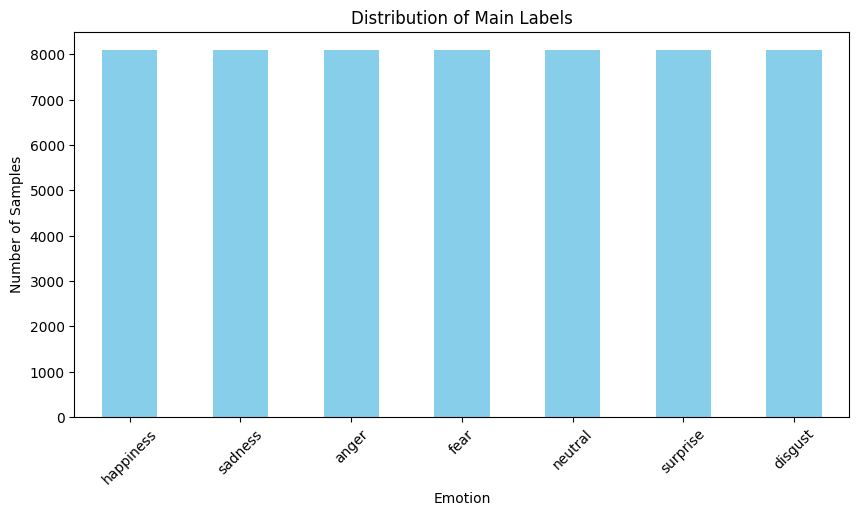

In [ ]:
label_counts = balanced_df['main_category'].value_counts()

# Plot distribution
plt.figure(figsize=(10, 5))
label_counts.plot(kind='bar', color='skyblue')
plt.title("Distribution of Main Labels")
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# drop duplicates
balanced_df.drop_duplicates(subset=['text'], inplace=True)

# Reset index
balanced_df.reset_index(drop=True, inplace=True)

# Verify new distribution
print("Original Class Distribution:\n", df["main_category"].value_counts())
print("Balanced Class Distribution (After Dropping Duplicates):\n", balanced_df["main_category"].value_counts())

Original Class Distribution:
 main_category
happiness    8091
sadness      5328
anger        2516
fear         2289
neutral      1077
surprise      807
disgust        19
Name: count, dtype: int64
Balanced Class Distribution (After Dropping Duplicates):
 main_category
happiness    8089
sadness      8089
anger        8088
fear         8084
surprise     8082
neutral      7990
disgust      6897
Name: count, dtype: int64


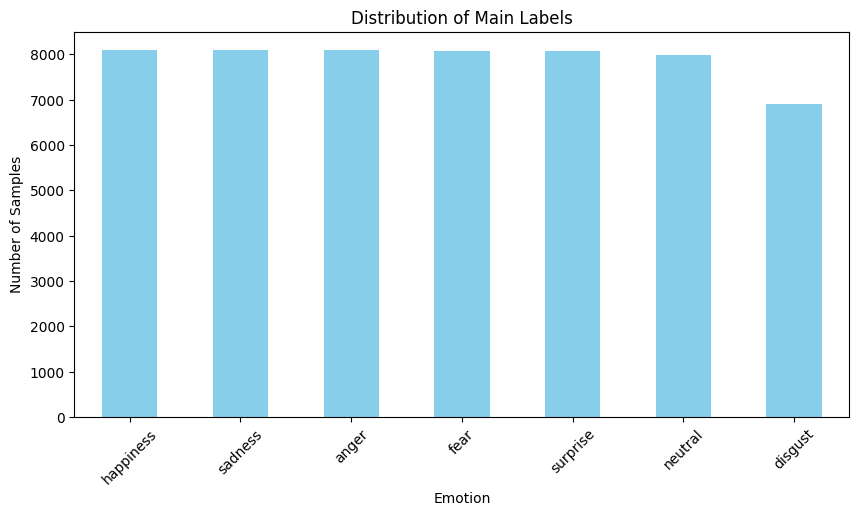

In [ ]:
label_counts = balanced_df['main_category'].value_counts()

# Plot distribution
plt.figure(figsize=(10, 5))
label_counts.plot(kind='bar', color='skyblue')
plt.title("Distribution of Main Labels")
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Find the minimum number of samples in any category
min_count = balanced_df["main_category"].value_counts().min()

# Crop each category to the min_count
cropped_df = balanced_df.groupby("main_category").apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)

# Check the new distribution
print("New Balanced Class Distribution:\n", cropped_df["main_category"].value_counts())



New Balanced Class Distribution:
 main_category
anger        6897
disgust      6897
fear         6897
happiness    6897
neutral      6897
sadness      6897
surprise     6897
Name: count, dtype: int64


<ipython-input-22-f4afec4a1d29>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cropped_df = balanced_df.groupby("main_category").apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)


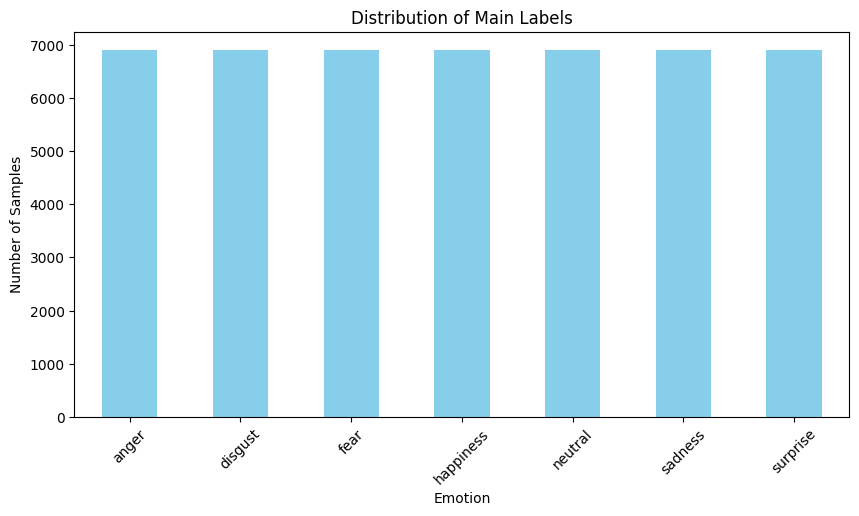

In [ ]:
label_counts = cropped_df['main_category'].value_counts()

# Plot distribution
plt.figure(figsize=(10, 5))
label_counts.plot(kind='bar', color='skyblue')
plt.title("Distribution of Main Labels")
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# download file
from google.colab import files
cropped_df.to_csv('vers2_data.csv', index=False)
files.download('vers2_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>